# 1. Preparations


## 1.1 Install Libararies
Install dependent libraries

In [1]:
!pip install torch torchvision matplotlib seaborn scikit-learn numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## 1.2. Import Libraries
Import all the dependent libraries

In [2]:
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

## 1.3. Check Device
Check whether use GPU or MPS(Apple Silicon) or CPU for computing

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 2. Prepare Dataset and Data

## 2.1. Define Dataset
Define a dataset for data augmentation and data sample

In [4]:
# Define data augmentation for training data
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),   # Random vertical flip
    transforms.RandomRotation(degrees=45),  # Random rotation within 45 degrees
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to mean=0.5 and std=0.5
])

# Define a basic transformation for validation and test data
basic_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize to mean=0.5 and std=0.5
])

# Wrap data in a custom Dataset with transforms
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img.to(device), label.to(device)



## 2.2. Load Data
Load data and labels from csv to tensor

In [5]:


# Load training and test data from the dataset folder
train_data = pd.read_csv('../dataset/fashion-mnist_train.csv')
test_data = pd.read_csv('../dataset/fashion-mnist_test.csv')

# Separate labels and pixel values
X_train = torch.tensor(train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28), dtype=torch.float32)
X_test = torch.tensor(test_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)
y_test = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.long)

# Define the split ratio
train_size = int(0.9 * X_train.shape[0])
val_size = X_train.shape[0] - train_size

# Create augmented datasets
train_dataset = CustomDataset(X_train[:train_size], y_train[:train_size], transform=data_augmentation)
val_dataset = CustomDataset(X_train[train_size:], y_train[train_size:], transform=basic_transforms)
test_dataset = CustomDataset(X_test, y_test, transform=basic_transforms)

# Confirm the sizes of train, validation, and test datasets
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

# DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Data is ready")


Train dataset size: 54000
Validation dataset size: 6000
Test dataset size: 10000
Data is ready


# 3. Define the Training & Testing Loop
Define the training and the testing function for model training and comparison

## 3.1. Define the Training Loop

In [6]:
def train(model, num_epochs=100):
    # Move the model to device
    model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Lists to track training and validation loss
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training and Validation Loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

## 3.2. Define the Testing Loop

In [7]:
def test(model):
    # Set the model to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=[
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ])
    print("Classification Report:\n", report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ], yticklabels=[
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# 4. Define and Compare Models
Define several model structures and compare their performance

## 4.1. MLPv1 (Baseline)
A basic model only with 3 linear layers

MLPv1(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=49, bias=True)
  (fc3): Linear(in_features=49, out_features=10, bias=True)
)


Epoch 1/100, Training Loss: 8.3647, Validation Loss: 1.6832, Validation Accuracy: 53.48%
Epoch 2/100, Training Loss: 1.6699, Validation Loss: 1.6403, Validation Accuracy: 51.80%
Epoch 3/100, Training Loss: 1.5603, Validation Loss: 1.5288, Validation Accuracy: 53.13%
Epoch 4/100, Training Loss: 1.4027, Validation Loss: 1.3445, Validation Accuracy: 55.50%
Epoch 5/100, Training Loss: 1.2795, Validation Loss: 1.1594, Validation Accuracy: 60.35%
Epoch 6/100, Training Loss: 1.1944, Validation Loss: 1.4191, Validation Accuracy: 49.02%
Epoch 7/100, Training Loss: 1.1700, Validation Loss: 1.1080, Validation Accuracy: 60.65%
Epoch 8/100, Training Loss: 1.1532, Validation Loss: 1.0964, Validation Accuracy: 61.00%
Epoch 9/100, Training Loss: 1.1433, Validation Loss: 1.1083, Validation Accuracy: 60.28%
Epoch 10/100, Training Loss: 1.1182, Validation Loss: 1.0399, Validation Accuracy: 61.68%
Epoch 11/100, Training Loss: 1.1173, Validation Loss: 1.1439, Validation Accuracy: 58.08%
Epoch 12/100, Train

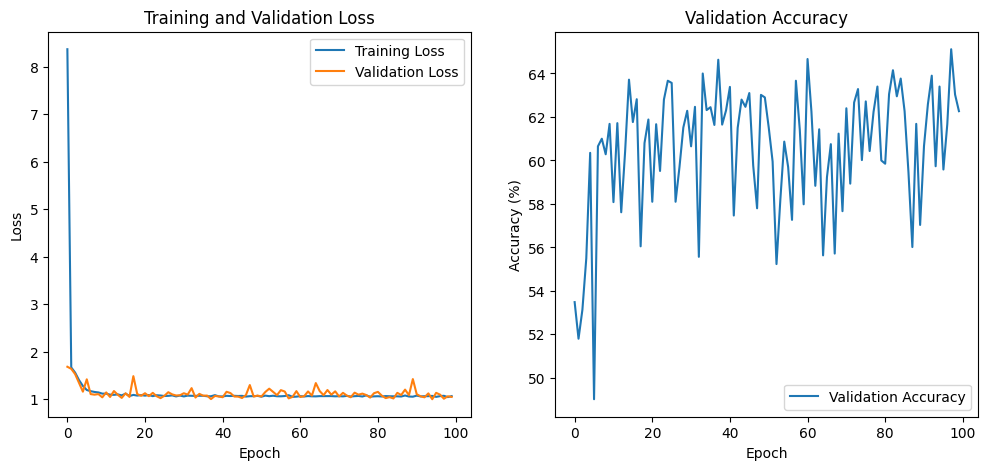

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.60      0.76      0.67      1000
     Trouser       0.97      0.75      0.84      1000
    Pullover       0.65      0.32      0.43      1000
       Dress       0.75      0.78      0.76      1000
        Coat       0.62      0.49      0.55      1000
      Sandal       0.67      0.68      0.68      1000
       Shirt       0.34      0.48      0.40      1000
     Sneaker       0.75      0.74      0.75      1000
         Bag       0.63      0.55      0.59      1000
  Ankle boot       0.61      0.84      0.71      1000

    accuracy                           0.64     10000
   macro avg       0.66      0.64      0.64     10000
weighted avg       0.66      0.64      0.64     10000



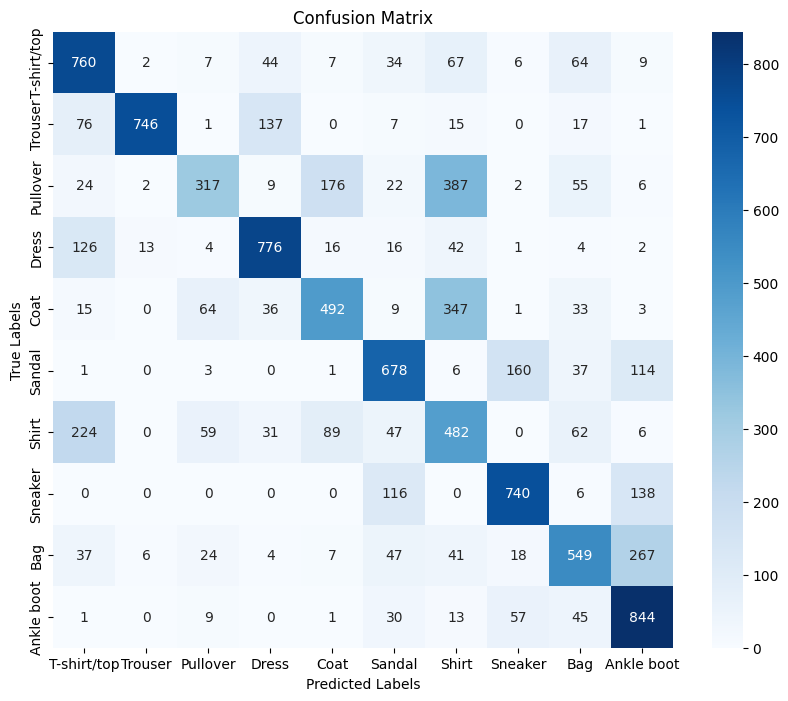

In [17]:
class MLPv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 196)
        self.fc2 = nn.Linear(196, 49)
        self.fc3 = nn.Linear(49, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten x from 2D to 1D
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

model = MLPv1()
print(model)
train(model)
test(model)

## 4.2. MLPv2
Add ReLU activation function

MLPv2(
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=49, bias=True)
  (fc3): Linear(in_features=49, out_features=10, bias=True)
)


Epoch 1/100, Training Loss: 1.9933, Validation Loss: 1.4436, Validation Accuracy: 45.32%
Epoch 2/100, Training Loss: 1.2895, Validation Loss: 1.0609, Validation Accuracy: 56.55%
Epoch 3/100, Training Loss: 1.0518, Validation Loss: 0.9506, Validation Accuracy: 63.60%
Epoch 4/100, Training Loss: 0.9277, Validation Loss: 0.8091, Validation Accuracy: 69.58%
Epoch 5/100, Training Loss: 0.8300, Validation Loss: 0.7981, Validation Accuracy: 69.82%
Epoch 6/100, Training Loss: 0.7858, Validation Loss: 0.7130, Validation Accuracy: 72.37%
Epoch 7/100, Training Loss: 0.7549, Validation Loss: 0.7049, Validation Accuracy: 73.82%
Epoch 8/100, Training Loss: 0.7425, Validation Loss: 0.7083, Validation Accuracy: 73.22%
Epoch 9/100, Training Loss: 0.7245, Validation Loss: 0.7074, Validation Accuracy: 73.15%
Epoch 10/100, Training Loss: 0.7120, Validation Loss: 0.6732, Validation Accuracy: 74.68%
Epoch 11/100, Training Loss: 0.7006, Validation Loss: 0.8176, Validation Accuracy: 69.02%
Epoch 12/100, Train

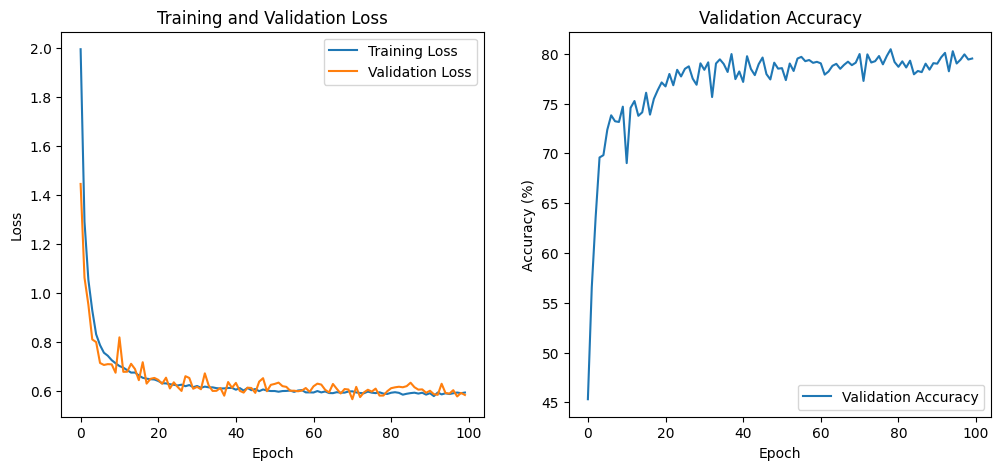

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.71      0.81      0.75      1000
     Trouser       0.93      0.94      0.93      1000
    Pullover       0.73      0.60      0.66      1000
       Dress       0.86      0.76      0.81      1000
        Coat       0.64      0.81      0.71      1000
      Sandal       0.89      0.90      0.90      1000
       Shirt       0.56      0.51      0.53      1000
     Sneaker       0.90      0.88      0.89      1000
         Bag       0.92      0.89      0.91      1000
  Ankle boot       0.91      0.92      0.92      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



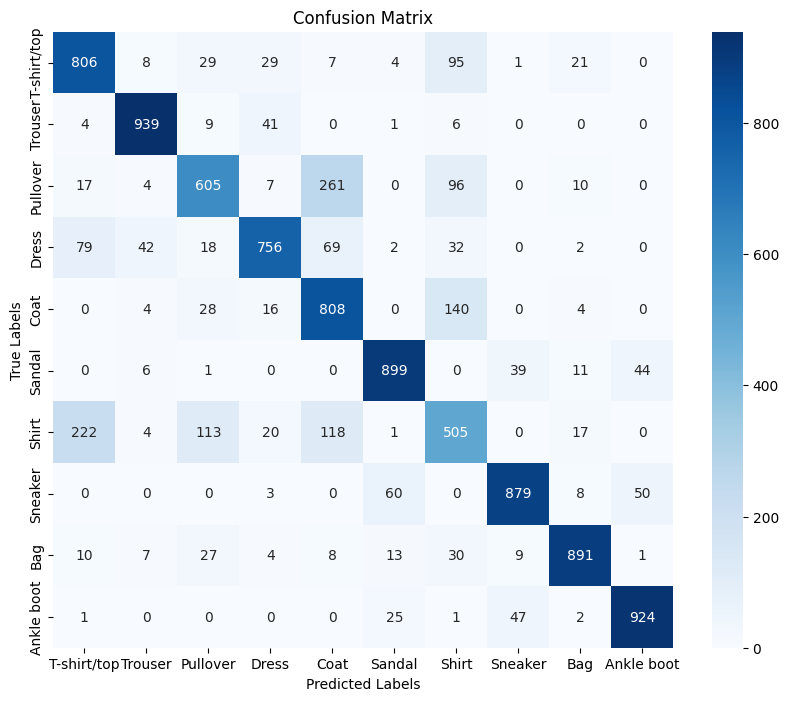

In [18]:
class MLPv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 196)
        self.fc2 = nn.Linear(196, 49)
        self.fc3 = nn.Linear(49, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten x from 2D to 1D
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MLPv2()
print(model)
train(model)
test(model)

## 4.3. CNNv1
Add four convolution layers

CNNv1(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=49, bias=True)
  (fc3): Linear(in_features=49, out_features=10, bias=True)
)


Epoch 1/100, Training Loss: 0.8376, Validation Loss: 0.6484, Validation Accuracy: 76.45%
Epoch 2/100, Training Loss: 0.6088, Validation Loss: 0.5448, Validation Accuracy: 80.22%
Epoch 3/100, Training Loss: 0.5512, Validation Loss: 0.5206, Validation Accuracy: 80.70%
Epoch 4/100, Training Loss: 0.5200, Validation Loss: 0.4855, Validation Accuracy: 81.68%
Epoch 5/100, Training Loss: 0.4971, Validation Loss: 0.4539, Validation Accuracy: 83.33%
Epoch 6/100, Training Loss: 0.4828, Validation Loss: 0.4638, Validation Accuracy: 82.97%
Epoch 7/100, Training Loss: 0.4701, Validation Loss: 0.4728, Validation Accuracy: 82.32%
Epoch 8/100, Training Loss: 0.4617, Validation Loss: 0.4419, Validation Accuracy: 83.67%
Epoch 9/100, Training Loss: 0.4471, Validation Loss: 0.4356, Validation Accuracy: 84.18%
Epoch 10/100, Training Loss: 0.4424, Validation Loss: 0.4357, Validation Accuracy: 84.82%
Epoch 11/100, Training Loss: 0.4313, Validation Loss: 0.4079, Validation Accuracy: 84.97%
Epoch 12/100, Train

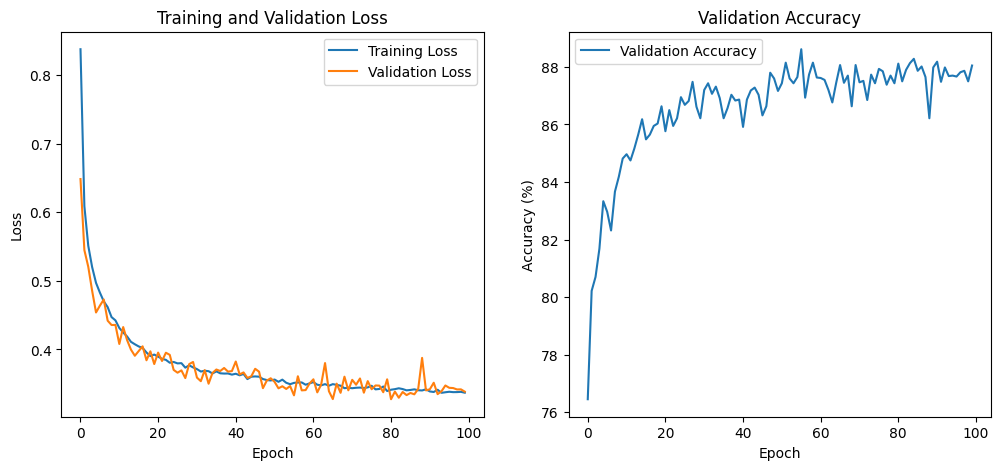

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.79      0.85      0.82      1000
     Trouser       0.96      0.98      0.97      1000
    Pullover       0.83      0.84      0.84      1000
       Dress       0.93      0.86      0.89      1000
        Coat       0.82      0.82      0.82      1000
      Sandal       0.98      0.94      0.96      1000
       Shirt       0.70      0.67      0.68      1000
     Sneaker       0.91      0.95      0.93      1000
         Bag       0.97      0.96      0.96      1000
  Ankle boot       0.94      0.95      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



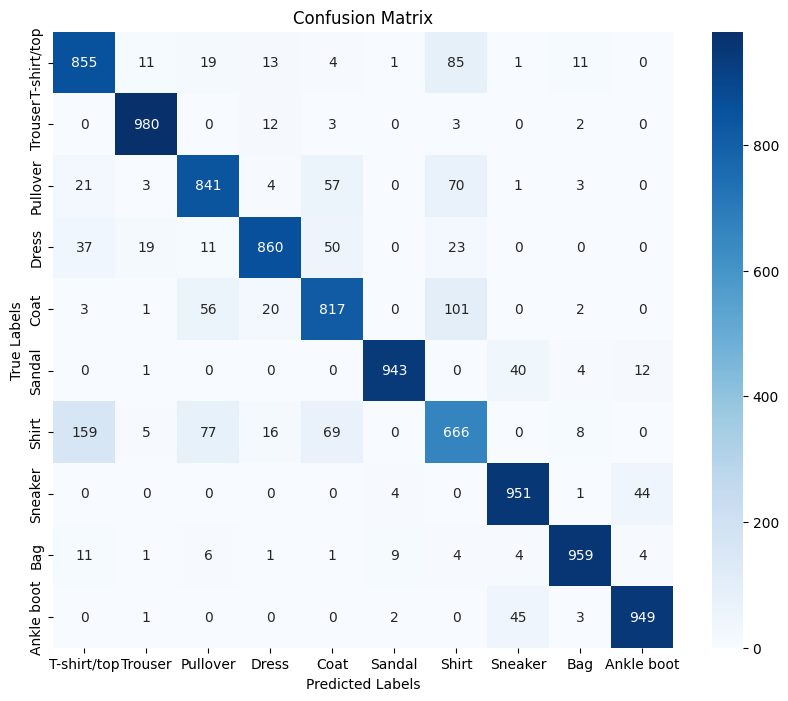

In [19]:
class CNNv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(8, 1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(784, 196)
        self.fc2 = nn.Linear(196, 49)
        self.fc3 = nn.Linear(49, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = CNNv1()
print(model)
train(model)
test(model)

## 4.4. CNNv2
Add max pooling layer and adjust convolution layer

CNNv2(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=49, bias=True)
  (fc3): Linear(in_features=49, out_features=10, bias=True)
)


Epoch 1/100, Training Loss: 0.7634, Validation Loss: 0.5408, Validation Accuracy: 79.50%
Epoch 2/100, Training Loss: 0.5449, Validation Loss: 0.4928, Validation Accuracy: 81.55%
Epoch 3/100, Training Loss: 0.4778, Validation Loss: 0.4463, Validation Accuracy: 83.13%
Epoch 4/100, Training Loss: 0.4406, Validation Loss: 0.4244, Validation Accuracy: 84.70%
Epoch 5/100, Training Loss: 0.4190, Validation Loss: 0.4369, Validation Accuracy: 83.70%
Epoch 6/100, Training Loss: 0.4035, Validation Loss: 0.3701, Validation Accuracy: 86.33%
Epoch 7/100, Training Loss: 0.3925, Validation Loss: 0.3616, Validation Accuracy: 87.03%
Epoch 8/100, Training Loss: 0.3830, Validation Loss: 0.3446, Validation Accuracy: 87.83%
Epoch 9/100, Training Loss: 0.3725, Validation Loss: 0.3451, Validation Accuracy: 87.58%
Epoch 10/100, Training Loss: 0.3684, Validation Loss: 0.3785, Validation Accuracy: 86.23%
Epoch 11/100, Training Loss: 0.3617, Validation Loss: 0.3408, Validation Accuracy: 87.85%
Epoch 12/100, Train

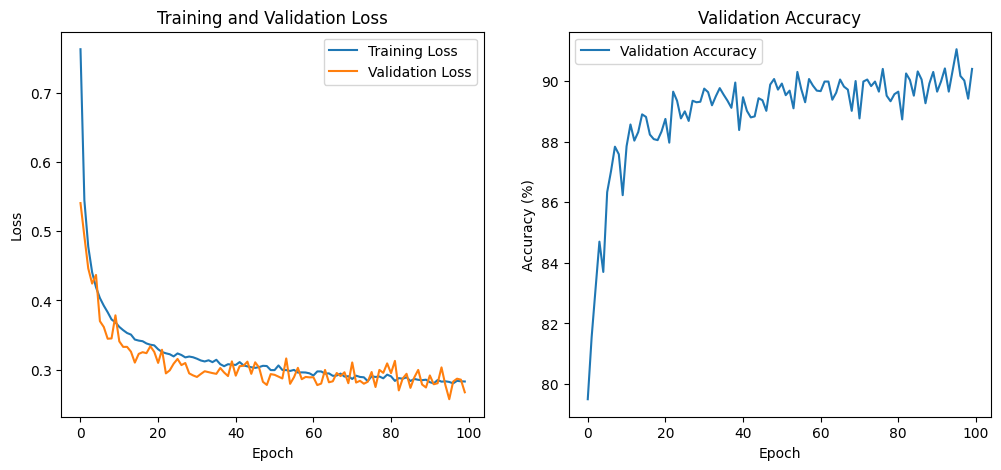

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.86      0.87      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.86      0.87      0.87      1000
       Dress       0.90      0.94      0.92      1000
        Coat       0.88      0.84      0.86      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.76      0.74      0.75      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.96      0.98      0.97      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



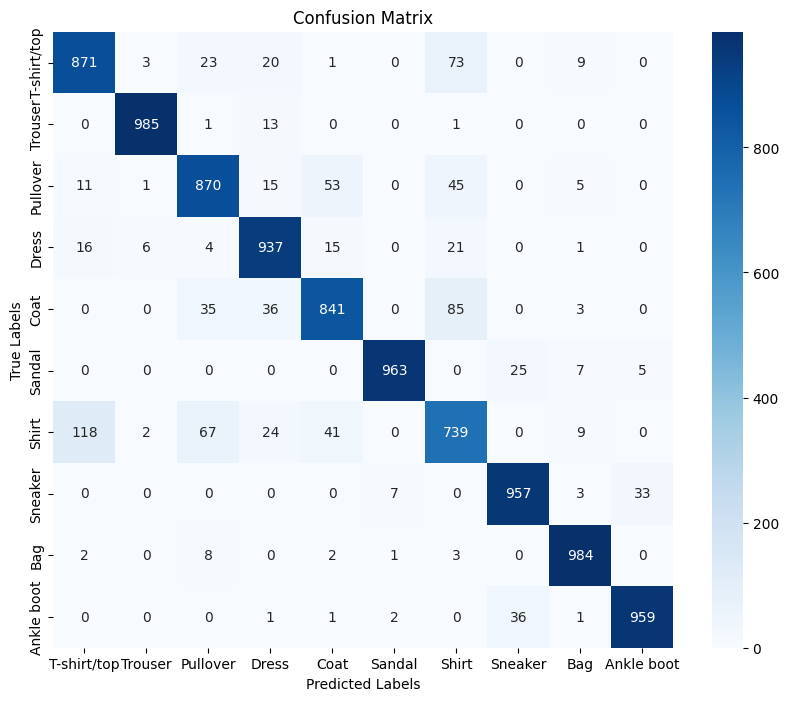

In [20]:
class CNNv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(784, 196)
        self.fc2 = nn.Linear(196, 49)
        self.fc3 = nn.Linear(49, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = CNNv2()
print(model)
train(model)
test(model)

## 4.5. CNNv3
Add drop out layer

CNNv3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=49, bias=True)
  (fc3): Linear(in_features=49, out_features=10, bias=True)
)


Epoch 1/100, Training Loss: 0.8655, Validation Loss: 0.5688, Validation Accuracy: 78.13%
Epoch 2/100, Training Loss: 0.6072, Validation Loss: 0.5211, Validation Accuracy: 80.70%
Epoch 3/100, Training Loss: 0.5398, Validation Loss: 0.4603, Validation Accuracy: 82.80%
Epoch 4/100, Training Loss: 0.5056, Validation Loss: 0.4070, Validation Accuracy: 85.05%
Epoch 5/100, Training Loss: 0.4719, Validation Loss: 0.3867, Validation Accuracy: 85.85%
Epoch 6/100, Training Loss: 0.4616, Validation Loss: 0.3857, Validation Accuracy: 86.18%
Epoch 7/100, Training Loss: 0.4434, Validation Loss: 0.3949, Validation Accuracy: 85.40%
Epoch 8/100, Training Loss: 0.4360, Validation Loss: 0.3861, Validation Accuracy: 85.83%
Epoch 9/100, Training Loss: 0.4253, Validation Loss: 0.3775, Validation Accuracy: 86.32%
Epoch 10/100, Training Loss: 0.4175, Validation Loss: 0.3826, Validation Accuracy: 86.35%
Epoch 11/100, Training Loss: 0.4110, Validation Loss: 0.3516, Validation Accuracy: 87.43%
Epoch 12/100, Train

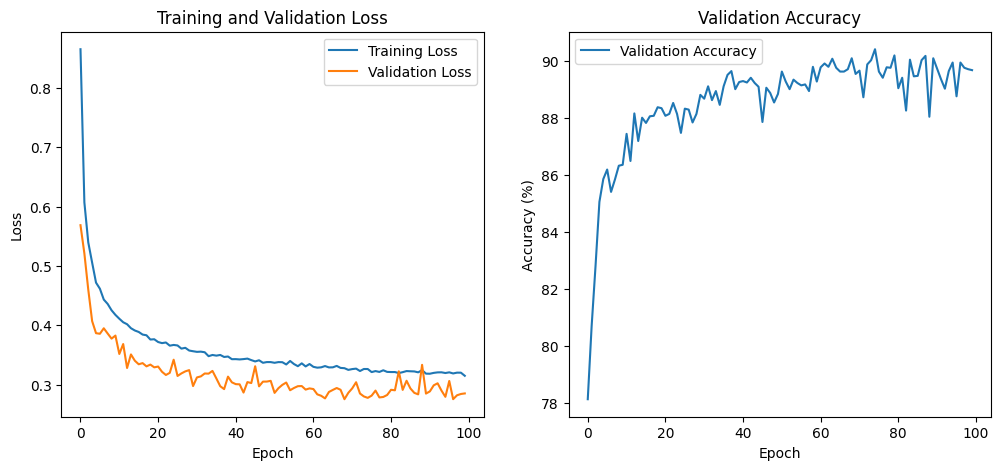

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.81      0.89      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.86      0.84      0.85      1000
       Dress       0.91      0.90      0.90      1000
        Coat       0.78      0.91      0.84      1000
      Sandal       1.00      0.92      0.96      1000
       Shirt       0.79      0.62      0.69      1000
     Sneaker       0.90      0.95      0.93      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.94      0.96      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



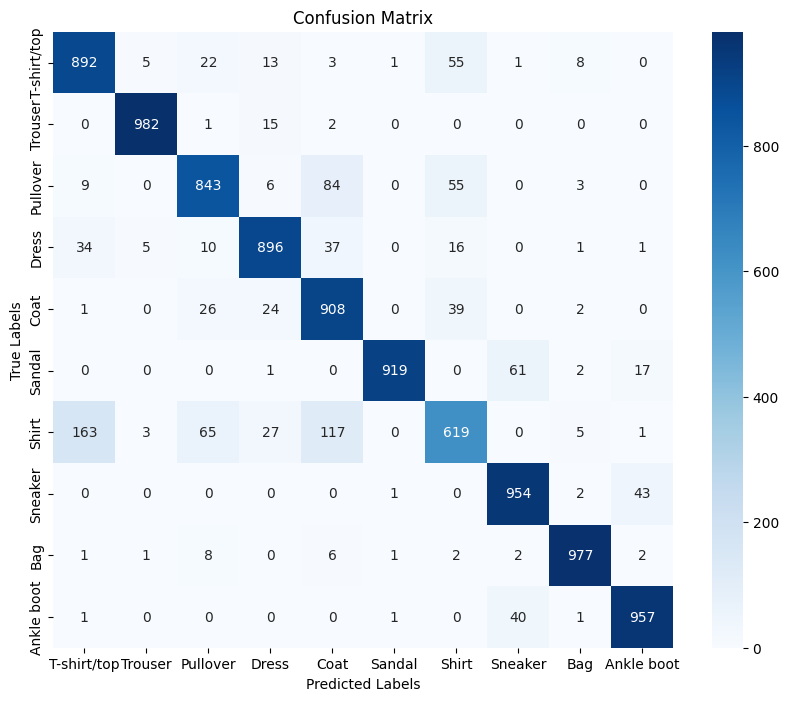

In [8]:
class CNNv3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(784, 196)
        self.fc2 = nn.Linear(196, 49)
        self.fc3 = nn.Linear(49, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = CNNv3()
print(model)
train(model)
test(model)

## 4.6. CNNv4
Add batch norm layer

CNNv4(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=784, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=49, bias=True)
  (fc3): Linear(in_features=49, out_features=10, bias=True)
)


Epoch 1/100, Training Loss: 0.7811, Validation Loss: 0.5958, Validation Accuracy: 77.48%
Epoch 2/100, Training Loss: 0.5551, Validation Loss: 0.4647, Validation Accuracy: 83.05%
Epoch 3/100, Training Loss: 0.4896, Validation Loss: 0.4363, Validation Accuracy: 83.73%
Epoch 4/100, Training Loss: 0.4554, Validation Loss: 0.3858, Validation Accuracy: 86.30%
Epoch 5/100, Training Loss: 0.4284, Validation Loss: 0.3795, Validation Accuracy: 85.77%
Epoch 6/100, Training Loss: 0.4111, Validation Loss: 0.3686, Validation Accuracy: 86.32%
Epoch 7/100, Training Loss: 0.4006, Validation Loss: 0.3666, Validation Accuracy: 86.45%
Epoch 8/100, Training Loss: 0.3849, Validation Loss: 0.3540, Validation Accuracy: 87.40%
Epoch 9/100, Training Loss: 0.3781, Validation Loss: 0.3285, Validation Accuracy: 88.27%
Epoch 10/100, Training Loss: 0.3709, Validation Loss: 0.3603, Validation Accuracy: 87.37%
Epoch 11/100, Training Loss: 0.3624, Validation Loss: 0.3245, Validation Accuracy: 88.73%
Epoch 12/100, Train

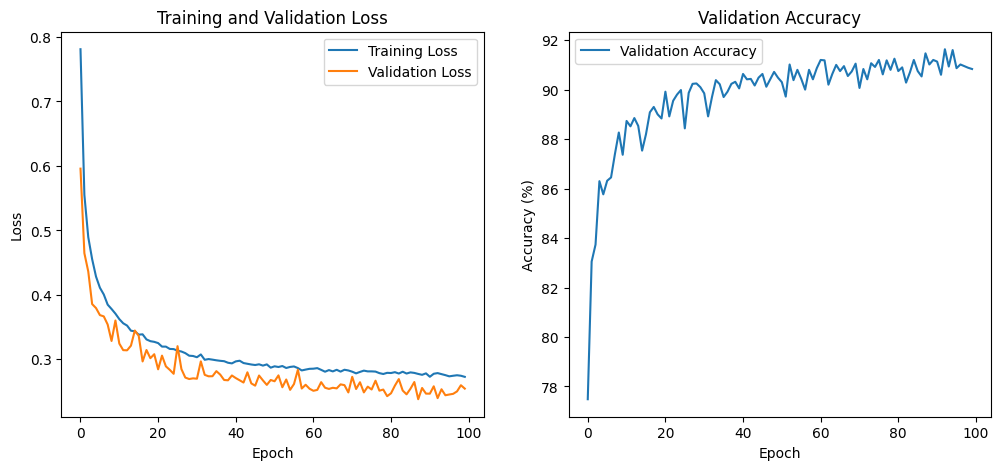

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.84      0.87      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.89      0.88      1000
       Dress       0.90      0.92      0.91      1000
        Coat       0.83      0.91      0.87      1000
      Sandal       0.99      0.96      0.97      1000
       Shirt       0.85      0.67      0.75      1000
     Sneaker       0.95      0.91      0.93      1000
         Bag       0.95      0.99      0.97      1000
  Ankle boot       0.91      0.98      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



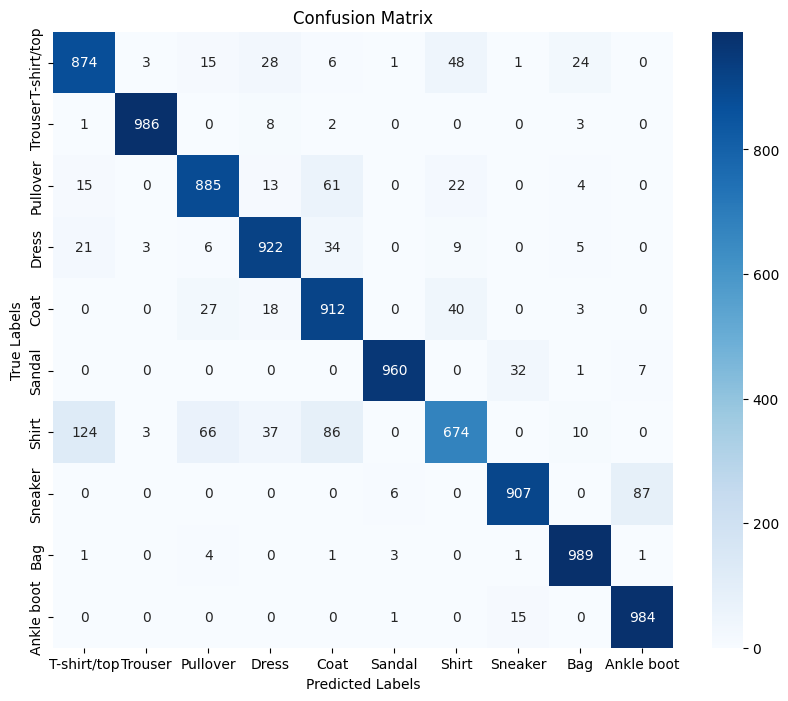

In [9]:
class CNNv4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(784, 196)
        self.fc2 = nn.Linear(196, 49)
        self.fc3 = nn.Linear(49, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = CNNv4()
print(model)
train(model)
test(model)

## 4.7. CNNv5
Add residual connection and adjust max pooling layer

CNNv5(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=31

Epoch 1/100, Training Loss: 0.8705, Validation Loss: 0.5914, Validation Accuracy: 76.65%
Epoch 2/100, Training Loss: 0.6176, Validation Loss: 0.5261, Validation Accuracy: 79.93%
Epoch 3/100, Training Loss: 0.5429, Validation Loss: 0.4435, Validation Accuracy: 82.68%
Epoch 4/100, Training Loss: 0.4988, Validation Loss: 0.4703, Validation Accuracy: 82.57%
Epoch 5/100, Training Loss: 0.4698, Validation Loss: 0.3931, Validation Accuracy: 85.45%
Epoch 6/100, Training Loss: 0.4446, Validation Loss: 0.3983, Validation Accuracy: 85.33%
Epoch 7/100, Training Loss: 0.4268, Validation Loss: 0.3718, Validation Accuracy: 86.42%
Epoch 8/100, Training Loss: 0.4100, Validation Loss: 0.3313, Validation Accuracy: 87.95%
Epoch 9/100, Training Loss: 0.4014, Validation Loss: 0.3344, Validation Accuracy: 88.13%
Epoch 10/100, Training Loss: 0.3888, Validation Loss: 0.3162, Validation Accuracy: 89.15%
Epoch 11/100, Training Loss: 0.3811, Validation Loss: 0.3893, Validation Accuracy: 86.05%
Epoch 12/100, Train

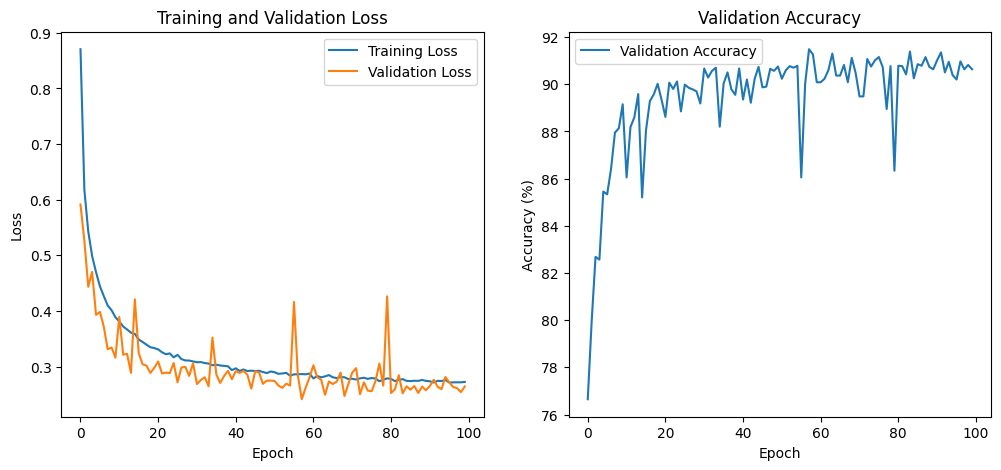

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.84      0.89      0.86      1000
     Trouser       0.97      0.99      0.98      1000
    Pullover       0.90      0.83      0.87      1000
       Dress       0.93      0.90      0.91      1000
        Coat       0.83      0.87      0.85      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.75      0.75      0.75      1000
     Sneaker       0.97      0.93      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.95      0.97      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



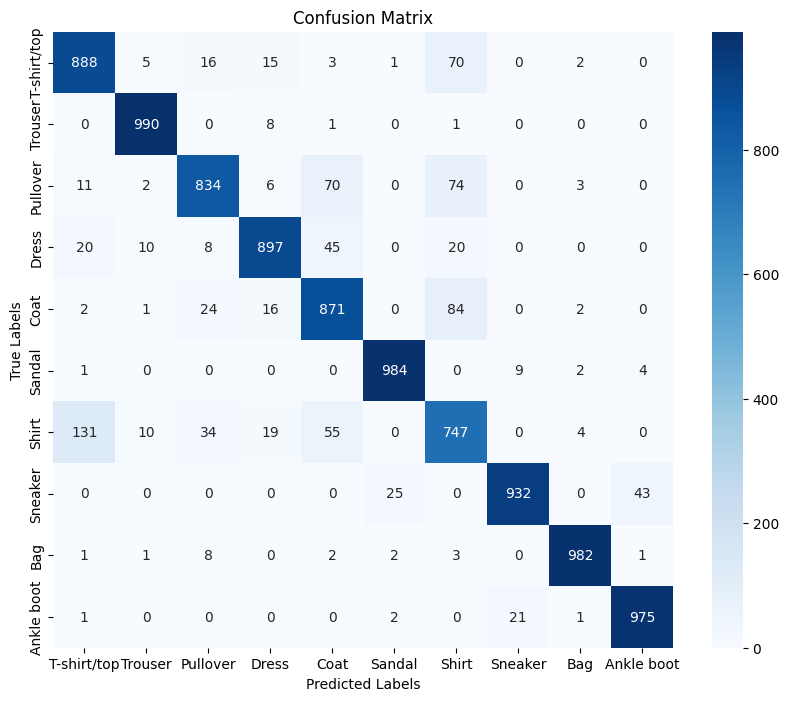

In [10]:
class CNNv5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64*7*7, 8*7*7)
        self.fc2 = nn.Linear(8*7*7, 7*7)
        self.fc3 = nn.Linear(7*7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x_raw = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(F.relu(self.bn3(self.conv3(x))) + x_raw)
        x_raw = x
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x))) + x_raw
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = CNNv5()
print(model)
train(model)
test(model)